In [3]:
# Image prepare

from PIL import Image
import hashlib, base64
import requests
import json

img_path = "0a7e5f62-5255-4ce3-a308-0e1c3258308d/1749631773485.jpg"
img = Image.open(img_path)
#display(img)

# load as binary
with open(img_path, "rb") as f:
    img_bytes = f.read()
img_bytes_size = len(img_bytes) # need size later

# Define API key
API_KEY = "f778022e6a3dd768579f3ea7"
SECRET_KEY = "913b98802da6092fd495a8b9b982730a"

# Get checksum, need later in base64 format
md5_digest = hashlib.md5(img_bytes).digest()
md5_base64 = base64.b64encode(md5_digest).decode("utf-8")
print("MD5:", md5_digest)
print("MD5 Base64:", md5_base64)

# Get access token
url = "https://api-users.fishial.ai/v1/auth/token"

payload = {
    "client_id": API_KEY,
    "client_secret": SECRET_KEY
}

headers = {
    "Content-Type": "application/json"
}

response_token = requests.post(url, json=payload, headers=headers)
print("Status:", response_token.status_code) # 200 is OK
#print("Response JSON:", response.json())
response_token1 = response_token.json()
#token_type = "Bearer",
access_token = response_token1.get("access_token")
# token valid for 10 min


MD5: b'\xc1\x87\x1f\x03\xdbE\xc0\xae8\xbe|_\xb84\xfa\xd3'
MD5 Base64: wYcfA9tFwK44vnxfuDT60w==
Status: 200


In [4]:
# Prepare and upload image
url = "https://api.fishial.ai/v1/recognition/upload"
headers = {
    "Accept": "application/json",
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json"
}

payload = {
    "blob": {
        "filename": "fishpic.jpg",
        "content_type": "image/jpeg",
        "byte_size": img_bytes_size,
        "checksum": md5_base64
    }
}

response_img = requests.post(url, headers=headers, json=payload)
response_img1 = response_img.json()
response_img1_headers = response_img1.get("direct-upload", {}).get("headers", {})
signed_id = response_img1.get("signed-id")

# Check status and print response
if response_img.status_code == 200:
    result = response_img.json()
    print(json.dumps(result, indent=2))
else:
    print(f"Error {response_img.status_code}: {response_img.text}")
    
url = response_img1.get("direct-upload", {}).get("url")
print("Upload URL:", url)

headers = {
    "Content-Disposition": response_img1_headers.get("Content-Disposition"),
    "Content-MD5": response_img1_headers.get("Content-MD5"),
    "Content-Type": ""
}

# Upload image
response_send = requests.put(url, headers=headers, data=img_bytes)

if response_send.status_code in [200, 201]:
    print("Upload successful!")
else:
    print(f"Error {response_send.status_code}: {response_send.text}")


# Fish detection - uses 1 credit per image
url = "https://api.fishial.ai/v1/recognition/image?q=eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBNVJjRlE9PSIsImV4cCI6bnVsbCwicHVyIjoiYmxvYl9pZCJ9fQ%3D%3D--269b0ee106c8739e2248645965ad0fc868b20c7c"
params = {"q": signed_id}

headers = {
    "Authorization": f"Bearer {access_token}"
}

response_id = requests.get(url, headers=headers, params=params)

{
  "id": 11500529,
  "key": "se882f17fzlwx7dhhrqxbunb36dx",
  "filename": "fishpic.jpg",
  "content-type": "image/jpeg",
  "metadata": {},
  "byte-size": 222647,
  "checksum": "wYcfA9tFwK44vnxfuDT60w==",
  "created-at": "2025-09-09T19:59:32.984Z",
  "service-name": "google",
  "signed-id": "eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBL0Y3cnc9PSIsImV4cCI6bnVsbCwicHVyIjoiYmxvYl9pZCJ9fQ==--8cdea3f9696d5806acb444595b926d9f51aa2cde",
  "direct-upload": {
    "url": "https://storage.googleapis.com/backend-fishes-storage-prod/se882f17fzlwx7dhhrqxbunb36dx?GoogleAccessId=services-storage-client%40ecstatic-baton-230905.iam.gserviceaccount.com&Expires=1757448272&Signature=hiQ%2B5xMGnzCYoHBj%2BTI2QIhOE6esn9OePwXbtPoopH%2FBjQvDRYptbi%2FTE650sZAtmsdcaYBTTvMPO%2FmVs0tiJUnozKOHQ%2FemT6GA9flX3Ca3sng%2BnICGnbCiOGw4xdCjRI%2FE7QwkbStIaOMxH2OXpI3fRTa4OwzWnYCbWvb06%2BgaWU0mdvBceRdLwXiPoY85nJdO%2BvvxAINRngrotaa%2Bc6bDaQfI%2FbyuAVuiTS7jRnYcdMYAncrhkbKu%2FdDswL6wQurnHEZ8nJzqmoge%2FDRj0s4gSfJAYLx3msZPMfOZNSzitsTXC%2Fo

In [5]:
# Results
import pandas as pd

response_id1 = response_id.json()
results_id = response_id1.get("results", [])

species_accs = []
for i, r in enumerate(results_id, start=1):
    for s in r.get("species", []):
        name = s.get("name", "Unknown")
        accuracy = s.get("accuracy", 0.0)
        species_accs.append({
            "Fish": i,
            "Species": name,
            "Accuracy": accuracy
        })

# Convert to DataFrame
df_species_accs = pd.DataFrame(species_accs)
df_species_accs = df_species_accs.sort_values(by=["Fish", "Accuracy"], ascending=[True, False])

print(df_species_accs)

fish1_top = df_species_accs[df_species_accs["Fish"] == 1].sort_values(by="Accuracy", ascending=False).iloc[0]
print("Fish 1 top species:", fish1_top["Species"])

   Fish              Species  Accuracy
0     1  Coryphaena hippurus  0.978748
Fish 1 top species: Coryphaena hippurus


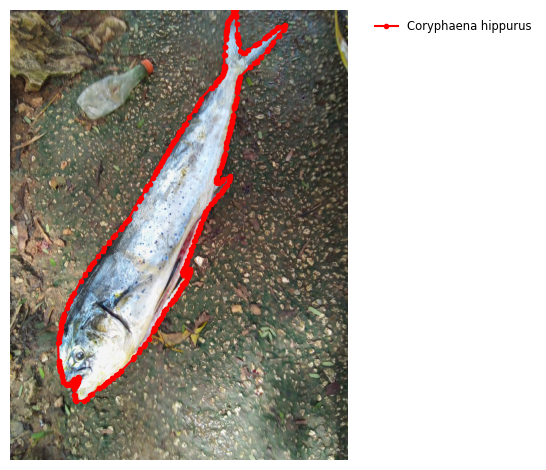

In [6]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

rrr = response_id1.get("results", [])
shape_coords = rrr[0]["shape"]

# Fix format
num_points = len(shape_coords) // 2
points_coords = [(shape_coords[f"x{i}"], shape_coords[f"y{i}"]) for i in range(1, num_points + 1)]

fish1_top_name = fish1_top["Species"]

# Plot on top of image
fig, ax = plt.subplots()
ax.imshow(img)
xs, ys = zip(*points_coords)
ax.plot(xs, ys, marker="o", color="red", linestyle="-", markersize=3, label=fish1_top_name)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), edgecolor='white', fontsize='small')
ax.axis('off')
plt.tight_layout() 

/var/folders/5k/drkcgngj2wlbtx0sm5b8mmdr0000gn/T/ipykernel_68153/2724994694.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(results_id))  # Use distinct colors


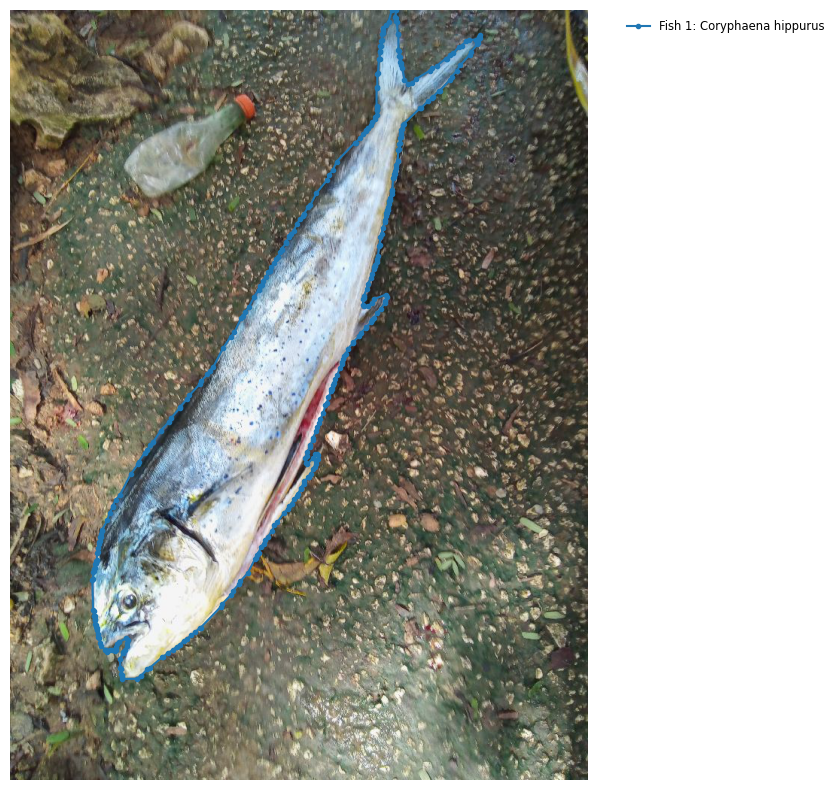

In [7]:
# Make plot all fish
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Results df
response_id1 = response_id.json()
results_id = response_id1.get("results", [])

species_accs = []
for i, r in enumerate(results_id, start=1):
    for s in r.get("species", []):
        species_accs.append({
            "Fish": i,
            "Species": s.get("name", "Unknown"),
            "Accuracy": s.get("accuracy", 0.0)
        })

df_species_accs = pd.DataFrame(species_accs)
df_species_accs = df_species_accs.sort_values(by=["Fish", "Accuracy"], ascending=[True, False])

# Filter species with highest accuracy per fish
top_species_per_fish = df_species_accs.groupby("Fish").first().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)

colors = plt.cm.get_cmap("tab10", len(results_id))  # Use distinct colors

for i, r in enumerate(results_id, start=1):
    shape_coords = r["shape"]
    num_points = len(shape_coords) // 2
    points_coords = [(shape_coords[f"x{j}"], shape_coords[f"y{j}"]) for j in range(1, num_points + 1)]
    
    xs, ys = zip(*points_coords)
    fish_top_name = top_species_per_fish[top_species_per_fish["Fish"] == i]["Species"].values[0]
    
    ax.plot(xs, ys, marker="o", markersize=3, linestyle="-",
            color=colors(i-1), label=f"Fish {i}: {fish_top_name}")

ax.axis("off")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), edgecolor='white', fontsize='small')
plt.tight_layout()
plt.show()
